In [1]:
import json

with open('/home/ubuntu/experiments/rnn_cls_all_2024-06-16_20-12-35/info.json') as info_file:
    info = json.load(info_file)

In [2]:
import tensorflow as tf
from polimi.utils.tf_models.utils.build_sequences import build_history_seq, build_sequences_seq_iterator, N_CATEGORY, N_SENTIMENT_LABEL, N_SUBCATEGORY, N_TOPICS, N_HOUR_GROUP, N_WEEKDAY
from polimi.utils.tf_models import TemporalConvolutionalHistoryClassificationModel
import json

with open('/home/ubuntu/experiments/rnn_conv_all_2024-06-17_14-48-01/info.json') as info_file:
    info = json.load(info_file)

model = TemporalConvolutionalHistoryClassificationModel(
    categorical_features=info['categorical_columns'],
    numerical_features=info['numerical_columns'],
    vocabulary_sizes=info['vocabulary_sizes'],
    seq_embedding_dims={
        'input_topics': (N_TOPICS + 1, 20, True),
        'input_subcategory': (N_SUBCATEGORY + 1, 20, True),
        'input_category': (N_CATEGORY + 1, 20, False),
        'input_weekday': (N_WEEKDAY, 3, False),
        'input_hour_group': (N_HOUR_GROUP, 3, False),
        'input_sentiment_label': (N_SENTIMENT_LABEL + 1, 2, False)
    },
    seq_numerical_features=['scroll_percentage', 'read_time', 'premium'],
    window_size=30,
    n_conv_layers=5,
    conv_filters=128,
    kernel_size=2,
    conv_activation='swish',
    l1_lambda=1e-4,
    l2_lambda=1e-4,
    dropout_rate=0.2,
    dense_n_layers=4,
    dense_start_units=384,
    dense_units_decay=2,
    dense_activation='swish',
)

model._build()
model.model.load_weights('/home/ubuntu/experiments/rnn_conv_all_2024-06-17_14-48-01/checkpoints/checkpoint.weights.h5')

tf_model = model.model

2024-06-18 12:39:49.283743: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 12:39:49.362577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 12:39:52.503756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
input_keys = ['input_topics', 'input_subcategory', 'input_category', 'input_weekday',
              'input_hour_group', 'input_sentiment_label', 'input_numerical']

inputs = {key: tf_model.input[key] for key in input_keys}
inputs

{'input_topics': <KerasTensor shape=(None, 30, 79), dtype=float32, sparse=None, name=input_topics>,
 'input_subcategory': <KerasTensor shape=(None, 30, 263), dtype=float32, sparse=None, name=input_subcategory>,
 'input_category': <KerasTensor shape=(None, 30), dtype=float32, sparse=None, name=input_category>,
 'input_weekday': <KerasTensor shape=(None, 30), dtype=float32, sparse=None, name=input_weekday>,
 'input_hour_group': <KerasTensor shape=(None, 30), dtype=float32, sparse=None, name=input_hour_group>,
 'input_sentiment_label': <KerasTensor shape=(None, 30), dtype=float32, sparse=None, name=input_sentiment_label>,
 'input_numerical': <KerasTensor shape=(None, 30, 3), dtype=float32, sparse=None, name=input_numerical>}

In [4]:
import tensorflow.keras.layers as tfkl 

output = tf_model.get_layer('cropping1d').output

embedding_model = tf.keras.Model(inputs=inputs, outputs=output)
embedding_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_topics        │ (None, 30, 79)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_subcategory   │ (None, 30, 263)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_category      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_weekday       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_hour_group    │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_sentiment_la… │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_multi_hot… │ (None, 30, 20)    │      1,580 │ input_topics[0][… │
│ (SequenceMultiHotE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_multi_hot… │ (None, 30, 20)    │      5,260 │ input_subcategor… │
│ (SequenceMultiHotE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_21        │ (None, 30, 20)    │        660 │ input_category[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, 30, 3)     │         21 │ input_weekday[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, 30, 3)     │         18 │ input_hour_group… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_24        │ (None, 30, 2)     │          8 │ input_sentiment_… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_numerical     │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 30, 71)    │          0 │ sequence_multi_h… │
│ (Concatenate)       │                   │            │ sequence_multi_h… │
│                     │                   │            │ embedding_21[0][… │
│                     │                   │            │ embedding_22[0][… │
│                     │                   │            │ embedding_23[0][… │
│                     │                   │            │ embedding_24[0][… │
│                     │                   │            │ input_numerical[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv0 (Conv1D)      │ (None, 30, 128)   │     18,304 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 159,995 (624.98 KB)

 Trainable params: 158,715 (619.98 KB)

 Non-trainable params: 1,280 (5.00 KB)

In [5]:
from polimi.utils.tf_models.utils.build_sequences import build_history_seq, build_sequences_seq_iterator, N_CATEGORY, N_SENTIMENT_LABEL, N_SUBCATEGORY, N_TOPICS, N_HOUR_GROUP, N_WEEKDAY
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
import polars as pl
import joblib

history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

history_seq_train = build_history_seq(history_train, articles)

In [6]:
import numpy as np

multi_one_hot_cols = ['topics', 'subcategory']
categorical_cols = ['category', 'weekday', 'hour_group', 'sentiment_label']
# caterical_cols_num_classes = {key: history_seq[key].explode().max() + 1 for key in categorical_cols}  #uncomment if you don't want to hardcode
caterical_cols_num_classes = {
    'category': N_CATEGORY + 1,#+1 to handle null values
    'weekday': N_WEEKDAY,
    'hour_group': N_HOUR_GROUP,
    'sentiment_label': N_SENTIMENT_LABEL + 1 #+1 to handle null
}
#it can be hardcoded if needed
all_features = history_seq_train.drop('user_id').columns
name_idx_dict = {key: [i for i, col in enumerate(all_features) if col.startswith(key)] for key in multi_one_hot_cols + categorical_cols}
numerical_cols = ['scroll_percentage', 'read_time', 'premium']
name_idx_dict['numerical'] = [i for i, col in enumerate(all_features) if col in numerical_cols]

def last_history_window_generator(history_seq_trucated, record_order):
    for user_id, user_history in history_seq_trucated.partition_by(['user_id'], as_dict=True, maintain_order=False).items():
        
        x = user_history.drop('user_id').to_numpy()[0]
        x = np.array([np.array(x_i).astype(np.int32) for x_i in x])
        res_x = {}
        for key, idx in name_idx_dict.items():
            res_x[f'input_{key}'] = x[idx, :].T
            
        record_order.append(user_id[0])
            
        yield res_x

In [7]:
mask = 0
window = 30
history_seq_train_trucated = history_seq_train.with_columns(
    pl.all().exclude('user_id').list.reverse().list.eval(pl.element().extend_constant(mask, window)).list.reverse().list.tail(window).name.keep()
)
record_order = []

inference_dataset = tf.data.Dataset.from_generator(
    lambda : last_history_window_generator(history_seq_train_trucated, record_order),
    output_signature={
        'input_topics': tf.TensorSpec(shape=(window,N_TOPICS+1), dtype=tf.int32), # history topics sequence
        'input_category': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history category sequence
        'input_subcategory': tf.TensorSpec(shape=(window, N_SUBCATEGORY+1), dtype=tf.int32), # history subcategory sequence
        'input_weekday': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history weekday sequence
        'input_hour_group': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history hour_group sequence
        'input_sentiment_label': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history sentiment_label sequence
        'input_numerical': tf.TensorSpec(shape=(window, 3), dtype=tf.float32), # history (premium, read_time, scroll_percentage) sequence
    }
).batch(512)

embeddings = np.squeeze(embedding_model.predict(inference_dataset))
embeddings.shape

30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step


2024-06-18 12:41:01.664840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


(15143, 128)

In [8]:
import gc

del history_seq_train, history_train, history_seq_train_trucated
gc.collect()

user_embeddings_train = pl.DataFrame(record_order, schema=['user_id']).hstack(pl.from_numpy(embeddings, schema=[f'user_embedding_{i}' for i in range(embeddings.shape[1])]))
user_embeddings_train.head()

user_id,user_embedding_0,user_embedding_1,user_embedding_2,user_embedding_3,user_embedding_4,user_embedding_5,user_embedding_6,user_embedding_7,user_embedding_8,user_embedding_9,user_embedding_10,user_embedding_11,user_embedding_12,user_embedding_13,user_embedding_14,user_embedding_15,user_embedding_16,user_embedding_17,user_embedding_18,user_embedding_19,user_embedding_20,user_embedding_21,user_embedding_22,user_embedding_23,user_embedding_24,user_embedding_25,user_embedding_26,user_embedding_27,user_embedding_28,user_embedding_29,user_embedding_30,user_embedding_31,user_embedding_32,user_embedding_33,user_embedding_34,user_embedding_35,…,user_embedding_91,user_embedding_92,user_embedding_93,user_embedding_94,user_embedding_95,user_embedding_96,user_embedding_97,user_embedding_98,user_embedding_99,user_embedding_100,user_embedding_101,user_embedding_102,user_embedding_103,user_embedding_104,user_embedding_105,user_embedding_106,user_embedding_107,user_embedding_108,user_embedding_109,user_embedding_110,user_embedding_111,user_embedding_112,user_embedding_113,user_embedding_114,user_embedding_115,user_embedding_116,user_embedding_117,user_embedding_118,user_embedding_119,user_embedding_120,user_embedding_121,user_embedding_122,user_embedding_123,user_embedding_124,user_embedding_125,user_embedding_126,user_embedding_127
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
945351,-0.083943,-0.110891,-0.106119,-0.164012,-0.101736,-0.055374,-0.174212,-0.149371,-0.132744,-0.139402,-0.120088,-0.095114,-0.167961,-0.148067,-0.100544,-0.097149,-0.185791,-0.089492,-0.162683,-0.142244,-0.180295,-0.060753,-0.064844,-0.096664,0.039491,-0.036807,-0.045869,-0.116744,-0.090868,-0.097575,-0.059539,-0.021619,-0.04027,-0.106294,-0.102203,-0.024432,…,-0.128808,-0.171059,-0.004641,-0.096788,-0.091351,-0.182712,-0.066981,-0.182004,-0.081414,-0.121437,-0.218031,-0.140403,-0.080534,-0.047048,-0.033479,-0.054979,-0.1155,-0.086047,-0.006056,-0.098738,-0.167219,-0.161585,-0.000083,-0.168307,-0.103794,-0.052166,-0.25808,-0.10097,-0.046722,-0.200989,-0.087782,-0.048603,-0.178036,-0.162914,-0.112876,0.002816,-0.165692
1190605,-0.083943,-0.110891,-0.106119,-0.164012,-0.101736,-0.055374,-0.174212,-0.149371,-0.132744,-0.139402,-0.120088,-0.095114,-0.167961,-0.148067,-0.100544,-0.097149,-0.185791,-0.089492,-0.162683,-0.142244,-0.180295,-0.060753,-0.064844,-0.096664,0.039491,-0.036807,-0.045869,-0.116744,-0.090868,-0.097575,-0.059539,-0.021619,-0.04027,-0.106294,-0.102203,-0.024432,…,-0.128808,-0.171059,-0.004641,-0.096788,-0.091351,-0.182712,-0.066981,-0.182004,-0.081414,-0.121437,-0.218031,-0.140403,-0.080534,-0.047048,-0.033479,-0.054979,-0.1155,-0.086047,-0.006056,-0.098738,-0.167219,-0.161585,-0.000083,-0.168307,-0.103794,-0.052166,-0.25808,-0.10097,-0.046722,-0.200989,-0.087782,-0.048603,-0.178036,-0.162914,-0.112876,0.002816,-0.165692
2479907,-0.083943,-0.110891,-0.106119,-0.164012,-0.101736,-0.055374,-0.174212,-0.149371,-0.132744,-0.139402,-0.120088,-0.095114,-0.167961,-0.148067,-0.100544,-0.097149,-0.185791,-0.089492,-0.162683,-0.142244,-0.180295,-0.060753,-0.064844,-0.096664,0.039491,-0.036807,-0.045869,-0.116744,-0.090868,-0.097575,-0.059539,-0.021619,-0.04027,-0.106294,-0.102203,-0.024432,…,-0.128808,-0.171059,-0.004641,-0.096788,-0.091351,-0.182712,-0.066981,-0.182004,-0.081414,-0.121437,-0.218031,-0.140403,-0.080534,-0.047048,-0.033479,-0.054979,-0.1155,-0.086047,-0.006056,-0.098738,-0.167219,-0.161585,-0.000083,-0.168307,-0.103794,-0.052166,-0.25808,-0.10097,-0.046722,-0.200989,-0.087782,-0.048603,-0.178036,-0.162914,-0.112876,0.002816,-0.165692
478837,-0.083943,-0.110891,-0.106119,-0.164012,-0.101736,-0.055374,-0.174212,-0.149371,-0.132744,-0.139402,-0.120088,-0.095114,-0.167961,-0.148067,-0.100544,-0.09

In [9]:
del embeddings
gc.collect()

user_embeddings_train.describe()

statistic,user_id,user_embedding_0,user_embedding_1,user_embedding_2,user_embedding_3,user_embedding_4,user_embedding_5,user_embedding_6,user_embedding_7,user_embedding_8,user_embedding_9,user_embedding_10,user_embedding_11,user_embedding_12,user_embedding_13,user_embedding_14,user_embedding_15,user_embedding_16,user_embedding_17,user_embedding_18,user_embedding_19,user_embedding_20,user_embedding_21,user_embedding_22,user_embedding_23,user_embedding_24,user_embedding_25,user_embedding_26,user_embedding_27,user_embedding_28,user_embedding_29,user_embedding_30,user_embedding_31,user_embedding_32,user_embedding_33,user_embedding_34,…,user_embedding_91,user_embedding_92,user_embedding_93,user_embedding_94,user_embedding_95,user_embedding_96,user_embedding_97,user_embedding_98,user_embedding_99,user_embedding_100,user_embedding_101,user_embedding_102,user_embedding_103,user_embedding_104,user_embedding_105,user_embedding_106,user_embedding_107,user_embedding_108,user_embedding_109,user_embedding_110,user_embedding_111,user_embedding_112,user_embedding_113,user_embedding_114,user_embedding_115,user_embedding_116,user_embedding_117,user_embedding_118,user_embedding_119,user_embedding_120,user_embedding_121,user_embedding_122,user_embedding_123,user_embedding_124,user_embedding_125,user_embedding_126,user_embedding_127
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,…,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0,15143.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.3051e6,-0.083943,-0.110891,-0.106119,-0.164012,-0.101736,-0.055374,-0.174212,-0.149371,-0.132744,-0.139402,-0.120088,-0.095114,-0.167961,-0.148067,-0.100544,-0.097149,-0.185791,-0.089492,-0.162683,-0.142244,-0.180295,-0.060753,-0.064844,-0.096664,0.039491,-0.036807,-0.045869,-0.116744,-0.090868,-0.097575,-0.059539,-0.021619,-0.04027,-0.106294,-0.102203,…,-0.128808,-0.171059,-0.004641,-0.096788,-0.091351,-0.182712,-0.066981,-0.182004,-0.081414,-0.121437,-0.218031,-0.140403,-0.080534,-0.047048,-0.033479,-0.054979,-0.1155,-0.086047,-0.006056,-0.098738,-0.167219,-0.161585,-0.000083,-0.168307,-0.103794,-0.052166,-0.25808,-0.10097,-0.046722,-0.200989,-0.087782,-0.048603,-0.178036,-0.162914,-0.112876,0.002816,-0.165692
"""std""",742513.206472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5772e-9,6.7147e-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.1405e-11,6.0540e-11,0.0,0.0,…,0.0,0.0,6.5891e-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8327e-9,0.0,0.0,0.0,2.3274e-10,0.0,0.0,0.0,2.2361e-11,0.0,1.0486e-10,0.0,0.0,0.0,0.0,0.0,0.0,3.7136e-10,0.0,0.0,0.0,1.1448e-10,0.0
"""min""",10068.0,-0.083943,-0.110891,-0.106119,-0.164012,-0.101736,-0.055374,-0.174212,-0.149371,-0.132744,-0.139402,-0.120088,-0.095114,-0.167961,-0.148067,-0.100544,-0.097149,-0.185791,-0.089492,-0.162683,-0.142244,-0.180295,-0.060753,-0.064844,-0.096664,0.039491,-0.036807,-0.045869,-0.116744,-0.090868,-0.097575,-0.059539,-0.02161

In [10]:
train_ds = pl.read_parquet('/home/ubuntu/dset_complete/subsample/train_ds.parquet')

train_ds = train_ds.join(user_embeddings_train.with_columns(pl.col('user_id').cast(pl.UInt32)), on='user_id', how='left')
train_ds.write_parquet('/home/ubuntu/tmp_dataset/conv_embeddings_dataset/train_ds.parquet')

columns = [c for c in train_ds.columns if c != 'impression_time']

del train_ds
gc.collect()

0

In [11]:
history_val = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

history_seq_val = build_history_seq(history_val, articles)

mask = 0
window = 30
history_seq_trucated_val = history_seq_val.with_columns(
    pl.all().exclude('user_id').list.reverse().list.eval(pl.element().extend_constant(mask, window)).list.reverse().list.tail(window).name.keep()
)

record_order = []
inference_dataset = tf.data.Dataset.from_generator(
    lambda : last_history_window_generator(history_seq_trucated_val, record_order),
    output_signature={
        'input_topics': tf.TensorSpec(shape=(window,N_TOPICS+1), dtype=tf.int32), # history topics sequence
        'input_category': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history category sequence
        'input_subcategory': tf.TensorSpec(shape=(window, N_SUBCATEGORY+1), dtype=tf.int32), # history subcategory sequence
        'input_weekday': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history weekday sequence
        'input_hour_group': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history hour_group sequence
        'input_sentiment_label': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # history sentiment_label sequence
        'input_numerical': tf.TensorSpec(shape=(window, 3), dtype=tf.float32), # history (premium, read_time, scroll_percentage) sequence
    }
).batch(512)

embeddings = np.squeeze(embedding_model.predict(inference_dataset))

del history_seq_val, history_val, history_seq_trucated_val
gc.collect()

user_embeddings_val = pl.DataFrame(record_order, schema=['user_id']).hstack(pl.from_numpy(embeddings, schema=[f'user_embedding_{i}' for i in range(embeddings.shape[1])]))

del embeddings
gc.collect()

user_embeddings_val.describe()

30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step


2024-06-18 12:42:06.217711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


statistic,user_id,user_embedding_0,user_embedding_1,user_embedding_2,user_embedding_3,user_embedding_4,user_embedding_5,user_embedding_6,user_embedding_7,user_embedding_8,user_embedding_9,user_embedding_10,user_embedding_11,user_embedding_12,user_embedding_13,user_embedding_14,user_embedding_15,user_embedding_16,user_embedding_17,user_embedding_18,user_embedding_19,user_embedding_20,user_embedding_21,user_embedding_22,user_embedding_23,user_embedding_24,user_embedding_25,user_embedding_26,user_embedding_27,user_embedding_28,user_embedding_29,user_embedding_30,user_embedding_31,user_embedding_32,user_embedding_33,user_embedding_34,…,user_embedding_91,user_embedding_92,user_embedding_93,user_embedding_94,user_embedding_95,user_embedding_96,user_embedding_97,user_embedding_98,user_embedding_99,user_embedding_100,user_embedding_101,user_embedding_102,user_embedding_103,user_embedding_104,user_embedding_105,user_embedding_106,user_embedding_107,user_embedding_108,user_embedding_109,user_embedding_110,user_embedding_111,user_embedding_112,user_embedding_113,user_embedding_114,user_embedding_115,user_embedding_116,user_embedding_117,user_embedding_118,user_embedding_119,user_embedding_120,user_embedding_121,user_embedding_122,user_embedding_123,user_embedding_124,user_embedding_125,user_embedding_126,user_embedding_127
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,…,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0,15342.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.2954e6,-0.083943,-0.110891,-0.106119,-0.164012,-0.101736,-0.055374,-0.174212,-0.149371,-0.132744,-0.139402,-0.120088,-0.095114,-0.167961,-0.148067,-0.100544,-0.097149,-0.185791,-0.089492,-0.162683,-0.142244,-0.180295,-0.060753,-0.064844,-0.096664,0.039491,-0.036807,-0.045869,-0.116744,-0.090868,-0.097575,-0.059539,-0.021619,-0.04027,-0.106294,-0.102203,…,-0.128808,-0.171059,-0.004641,-0.096788,-0.091351,-0.182712,-0.066981,-0.182004,-0.081414,-0.121437,-0.218031,-0.140403,-0.080534,-0.047048,-0.033479,-0.054979,-0.1155,-0.086047,-0.006056,-0.098738,-0.167219,-0.161585,-0.000083,-0.168307,-0.103794,-0.052166,-0.25808,-0.10097,-0.046722,-0.200989,-0.087782,-0.048603,-0.178036,-0.162914,-0.112876,0.002816,-0.165692
"""std""",742533.86487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5892e-9,7.0346e-10,0.0,0.0,5.2090e-11,0.0,0.0,0.0,0.0,0.0,1.5038e-11,7.9558e-11,0.0,0.0,…,0.0,0.0,6.4748e-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8476e-9,0.0,0.0,0.0,2.3281e-10,0.0,0.0,0.0,2.1911e-11,0.0,8.5065e-11,0.0,0.0,0.0,0.0,0.0,0.0,3.6897e-10,0.0,0.0,0.0,1.1324e-10,0.0
"""min""",10200.0,-0.083943,-0.110891,-0.106119,-0.164012,-0.101736,-0.055374,-0.174212,-0.149371,-0.132744,-0.139402,-0.120088,-0.095114,-0.167961,-0.148067,-0.100544,-0.097149,-0.185791,-0.089492,-0.162683,-0.142244,-0.180295,-0.060753,-0.064844,-0.096664,0.039491,-0.036807,-0.045869,-0.116744,-0.090868,-0.097575,-0.059539,-0

In [12]:
val_ds = pl.read_parquet('/home/ubuntu/dset_complete/validation_ds.parquet')

val_ds = val_ds.join(user_embeddings_val.with_columns(pl.col('user_id').cast(pl.UInt32)), on='user_id', how='left')
val_ds.select(columns).write_parquet('/home/ubuntu/tmp_dataset/conv_embeddings_dataset/validation_ds.parquet')

del val_ds
gc.collect()

0

In [13]:
with open('/home/ubuntu/dset_complete/data_info.json') as data_info_file:
    data_info = json.load(data_info_file)

with open('/home/ubuntu/tmp_dataset/conv_embeddings_dataset/data_info.json', 'w') as data_info_file:
    json.dump(data_info, data_info_file)

In [14]:
! python /home/ubuntu/RecSysChallenge2024/src/polimi/scripts/catboost_training.py \
    -output_dir /home/ubuntu/tmp_dataset \
    -dataset_path /home/ubuntu/tmp_dataset \
    -catboost_params_file /home/ubuntu/tmp_dataset/params.json \
    -catboost_verbosity 20 \
    -model_name catboost_cls_embeddings

In [ ]:
! python /home/ubuntu/RecSysChallenge2024/src/polimi/scripts/inference.py \
   -output_dir /home/ubuntu/tmp_dataset \
   -dataset_path /home/ubuntu/tmp_dataset \
   -model_path /home/ubuntu/tmp_dataset/catboost_cls_embeddings/model.joblib \
   -behaviors_path /home/ubuntu/dataset/ebnerd_small/validation/behaviors.parquet \
   -batch_size 1000000 \
   --eval

2024-06-16 14:56:44,658:root:INFO: Loading the preprocessed dataset from /home/ubuntu/tmp_dataset
2024-06-16 14:56:44,658:root:INFO: Data info: {'type': 'train', 'categorical_columns': ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday', 'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article', 'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory', 'article_type', 'postcode', 'Entity_ORG_Present', 'Entity_EVENT_Present', 'Entity_LOC_Present', 'Entity_MISC_Present', 'Entity_PER_Present', 'Entity_PROD_Present'], 'unique_entities': ['ORG', 'EVENT', 'LOC', 'MISC', 'PER', 'PROD'], 'timestamp': '2024-05-15_20-55-25'}
2024-06-16 14:56:44,658:root:INFO: Categorical features: ['device_type' 'is_sso_user' 'gender' 'is_subscriber' 'weekday' 'premium'
 'category' 'sentiment_label' 'is_new_article' 'is_already_seen_article'
 'MostFrequentCategory' 'MostFrequentWeekday' 'IsFavouriteCategory'
 'article_type' 'postcode' 'Entity_ORG_Present' '

<Axes: >

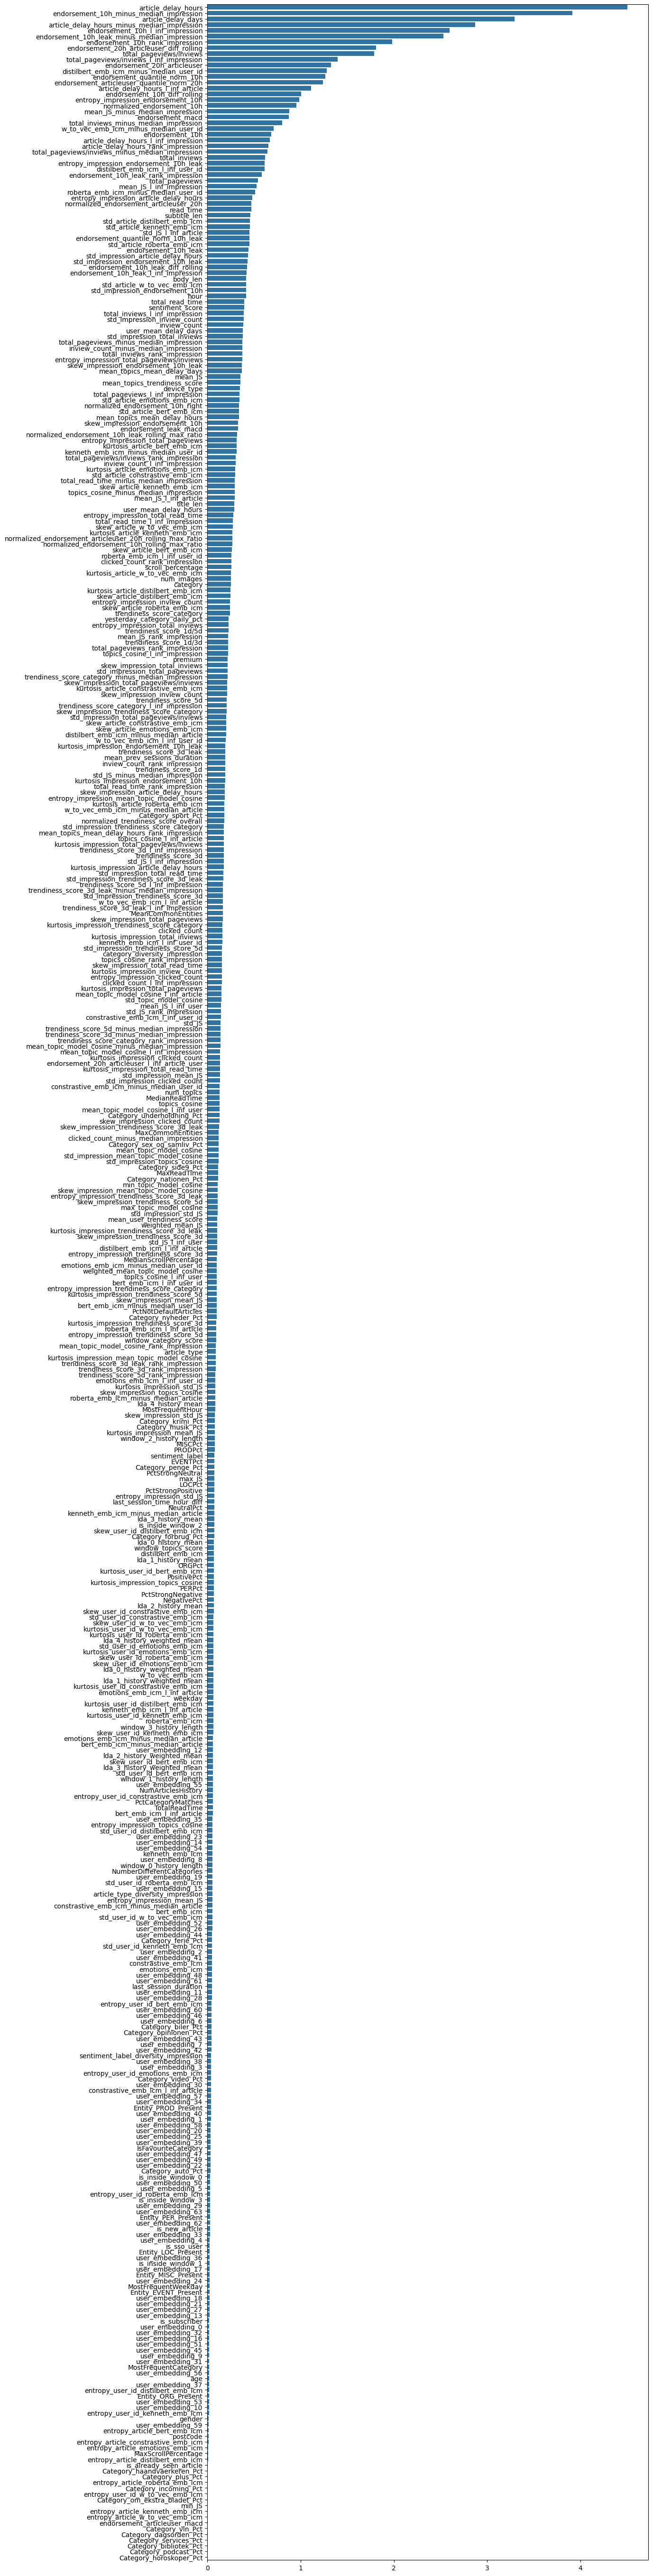

In [ ]:
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model = joblib.load('/home/ubuntu/tmp_dataset/catboost_cls_embeddings/model.joblib')

fi = model.feature_importances_
fn = model.feature_names_

sorted_indices = np.argsort(fi)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(12, 70))
sns.barplot(x=fi[sorted_indices], y=np.array(fn)[sorted_indices])